In [1]:
import torch as tr
import torch.nn as nn
import torch.nn.functional as F
from torch import distributions
from torch.nn.parameter import Parameter
import normflows as nf
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
L=8 # the length of the lattice which is going to be L x L torus
V=L*L # the volume

In [3]:
X = np.array(np.arange(L))[:,np.newaxis]
Y = np.array(np.arange(L))[np.newaxis,:]
#X = X[:,np.newaxis]

X = np.repeat(X,L,axis=1)
Y = np.repeat(Y,L,axis=0)
mm = (X+Y)%2
mm

array([[0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 0, 1, 0, 1, 0]])

In [4]:
lm = mm.reshape(V) # the mask

In [5]:
latent_size=V

In [6]:
b = tr.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
K=16

In [7]:
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]


In [8]:
class phi4(nn.Module):
    """
    Two-dimensional scalar phi4
    """

    def __init__(self, mass, lam,lat, Nd=2):
        """Constructor
        Args:
          n_modes: Number of modes
        """
        super(phi4, self).__init__()
        self.mass = 2*Nd+mass
        self.Nd = Nd
        self.lam = lam
        self.lat = lat
        self.V = np.prod(lat)
        #self.register_buffer(
        #    "scale", torch.tensor(2 / 3 * np.sin(np.pi / self.n_modes)).float()
        #)

    def log_prob(self, x):
        b=x.shape[0]
        xx = x.view(b,self.lat[0],self.lat[1])
        A = 0.5*self.mass*tr.sum(x*x,dim=1) + (self.lam/24.0)*tr.sum(x*x*x*x,dim=1)
        
        for mu in range(1,self.Nd+1):
            A = A - tr.sum((xx*tr.roll(xx,shifts=-1,dims=mu)).view(b,self.V),dim=1)
        return -A

    def sample(self, num_samples=1):
        return tr.zeros(100,num_samples)

In [37]:
p4=phi4(-0.2,0.5,[L,L])
base = nf.distributions.base.DiagGaussian(V)
model = nf.NormalizingFlow(base, flows,p4)
# Train model
max_iter = 10000
batch_size = 2 ** 12
show_iter = 500
loss_hist = np.array([])
optimizer = tr.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)


optimizer.zero_grad()
loss = model.reverse_kld(num_samples=batch_size)

In [38]:
loss_hist = np.array([])

100%|█████████████████████████████████████| 10000/10000 [21:08<00:00,  7.88it/s]


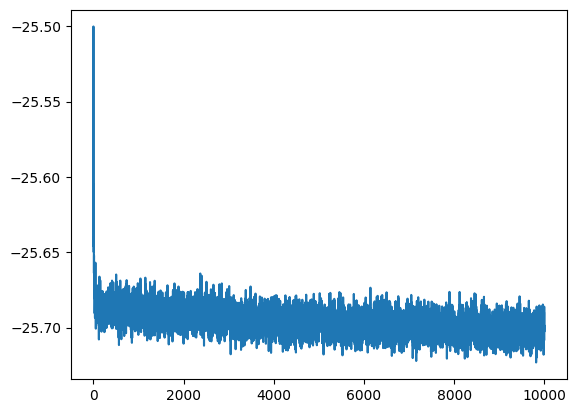

In [39]:
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    loss = model.reverse_kld(num_samples=batch_size)
    loss_hist = np.append(loss_hist,loss.to('cpu').data.numpy())
    # Optimization as usual
    loss.backward()
    optimizer.step()
    
plt.plot(np.arange(loss_hist.size),loss_hist)
    

In [40]:
(x,logp)=model.sample(4096)

In [41]:
diff=-p4.log_prob(x) + logp

In [42]:
m_diff = diff.mean()
diff -= m_diff

In [43]:

print("max  action diff: ", tr.max(diff.abs()).detach().numpy())
print("min  action diff: ", tr.min(diff.abs()).detach().numpy())
print("mean action diff: ", m_diff.detach().detach().numpy())
print("std  action diff: ", diff.std().detach().numpy())

max  action diff:  1.9300842
min  action diff:  0.000118255615
mean action diff:  -25.6992
std  action diff:  0.38648328


In [44]:
foo = tr.exp(-diff)
#print(foo)
w = foo/tr.mean(foo)

print("mean re-weighting factor: " , w.mean().detach().numpy())
print("std  re-weighting factor: " , w.std().detach().numpy())


mean re-weighting factor:  1.0000001
std  re-weighting factor:  0.39944205


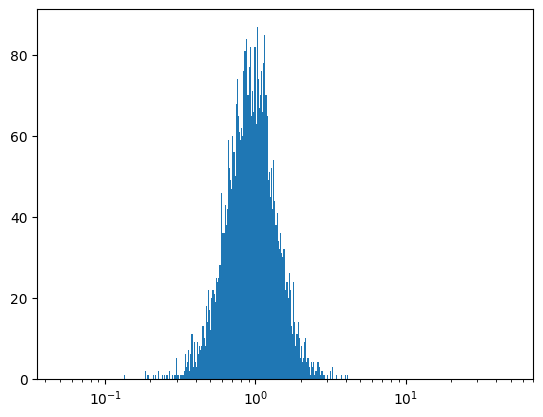

In [45]:
logbins = np.logspace(np.log10(5e-2),np.log10(5e1),int(w.shape[0]/10))
plt.hist(w.detach(),bins=logbins)
plt.xscale('log')

In [46]:
c=0
for tt in model.parameters():
    #print(tt.shape)
    if tt.requires_grad==True :
        c+=tt.numel()
        
print("parameter count: ",c)

parameter count:  532608
